# <center>Disease Mitigation</center>
### <center>Alina Vereshchaka - avereshc@buffalo.edu</center>
### <center>Nitin Kulkarni - nitinvis@buffalo.edu</center>

In [1]:
# Imports
from collections import deque
import gym
from gym import spaces
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import time
import logging

In c:\program files\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\program files\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\program files\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In c:\program files\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\program files\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_tes

In [2]:
# This ensures that all the data isn't loaded into the GPU memory at once.
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

# Disables eager execution.
tf.compat.v1.disable_eager_execution()

# Disables Tensorflow messages.
logging.getLogger('tensorflow').disabled = True

### The Disease Mitigation Environment:

In [3]:
# Defining the Disease Mitigation Environment.
class DiseaseMitigation(gym.Env):
    """This class implements the Disease Mitigation environment."""

    def __init__(self, environment_type):
        """This method initializes the environment.

        :param environment_type: - (It can take two values: 1. 'deterministic' 2. 'stochastic' indicating the type of
                                    environment. Note: This logic hasn't been implemented yet.)"""

        self.environment_type = environment_type  # This indicates whether the environment is of the type deterministic
                                                  # or stochastic. Note: This logic hasn't been implemented yet.
        self.observation_space = spaces.Discrete(4)  # This defines that there are 3 states in the environment.
        self.action_space = spaces.Discrete(2)  # This defines that there are 2 discrete actions that the agent can
                                                # perform.
        self.number_of_healthy_people = 18_958_776
        self.number_of_infected_people = 65_935
        self.number_of_recovered_people = 395_584
        self.number_of_dead_people = 33_266
        self.population = 19_453_561
        self.gdp_percentage = 100
        # We can control the infection rate to model for various diseases. This is beta as per the paper.
        self.infection_rate_lockdown = 0.003238120911279946
        self.infection_rate_no_lockdown = 0.0317561128108675
        self.gdp_coefficient = 1
        self.infection_coefficient = 45
        self.penalty_coefficient = 10
        self.removed_coefficient = 45
        self.number_of_healthy_people_list = [self.number_of_healthy_people]
        self.number_of_infected_people_list = [self.number_of_infected_people]
        self.number_of_recovered_people_list = [self.number_of_recovered_people]
        self.number_of_dead_people_list = [self.number_of_dead_people]
        self.gdp_list = [self.gdp_percentage]
        self.max_timesteps = 180
        self.timestep = 0
        self.lockdown_period = 7
        self.action_history = []
        self.action_counter = 0
        self.covid_data = pd.read_csv('./covid_ny.csv')

    def reset(self):
        """This method resets the environment and returns the state as the observation.

        :returns observation: - (Vector containing the normalized count of number of healthy people, infected people
                                and hospitalized people.)"""

        self.number_of_healthy_people = 18_958_776
        self.number_of_infected_people = 65_935
        self.number_of_recovered_people = 395_584
        self.number_of_dead_people = 33_266
        self.gdp_percentage = 100
        self.number_of_healthy_people_list = [self.number_of_healthy_people]
        self.number_of_infected_people_list = [self.number_of_infected_people]
        self.number_of_recovered_people_list = [self.number_of_recovered_people]
        self.number_of_dead_people_list = [self.number_of_dead_people]
        self.gdp_list = [self.gdp_percentage]
        self.timestep = 0
        self.action_history = []
        self.action_counter = 0
        previous_action = 1

        observation = [self.number_of_infected_people / self.population, self.gdp_percentage / 100,
                       previous_action, self.action_counter]

        return observation

    def step(self, action):
        """This method implements what happens when the agent takes a particular action. It changes the rate at which
        new people are infected, defines the rewards for the various states, and determines when the episode ends.

        :param action: - (Integer in the range 0 to 1 inclusive.)

        :returns observation: - (Vector containing the normalized count of number of healthy people, infected people
                                and hospitalized people.)
                 reward: - (Float value that's used to measure the performance of the agent.)
                 done: - (Boolean describing whether or not the episode has ended.)
                 info: - (A dictionary that can be used to provide additional implementation information.)"""

        self.action_history.append(action)

        if len(self.action_history) == 1:
            previous_action = 1
        else:
            previous_action = self.action_history[-2]

        penalty = 0

        if len(self.action_history) == 1:
            self.action_counter += 1

        if len(self.action_history) > 1:
            if self.action_history[-1] != self.action_history[-2]:
                if self.action_counter < self.lockdown_period:
                    penalty = 1
                self.action_counter = 1
            else:
                self.action_counter += 1
                if self.action_counter > self.lockdown_period:
                    self.action_counter = self.lockdown_period
                penalty = 0

        if action == 0:  # This action represents not going into lockdown.
            self.number_of_healthy_people -= np.random.poisson(
                self.infection_rate_no_lockdown * self.number_of_healthy_people *
                self.number_of_infected_people / self.population)
            self.number_of_dead_people += np.random.binomial(
                n=self.number_of_infected_people,
                p=abs(self.covid_data['Daily Death Rate (%)'][self.timestep + 203] / 100))
            self.number_of_infected_people = self.population - self.number_of_healthy_people - \
                                             self.number_of_dead_people - self.number_of_recovered_people
            number_of_people_that_recover = np.random.binomial(
                n=self.number_of_infected_people,
                p=abs(self.covid_data['Daily Recovery Rate (%)'][self.timestep + 203] / 100))
            self.number_of_recovered_people += number_of_people_that_recover
            self.number_of_infected_people -= number_of_people_that_recover
            number_of_reinfected_people = np.random.poisson(
                self.infection_rate_no_lockdown / 10 * self.number_of_recovered_people *
                self.number_of_infected_people / self.population)
            self.number_of_recovered_people -= number_of_reinfected_people
            self.number_of_infected_people += number_of_reinfected_people

            if self.gdp_percentage < 100:
                self.gdp_percentage *= 1.01
            if self.gdp_percentage > 100:
                self.gdp_percentage = 100

        elif action == 1:  # This action represents going into lockdown.
            self.number_of_healthy_people -= np.random.poisson(
                self.infection_rate_lockdown * self.number_of_healthy_people *
                self.number_of_infected_people / self.population)
            self.number_of_dead_people += np.random.binomial(
                n=self.number_of_infected_people,
                p=abs(self.covid_data['Daily Death Rate (%)'][self.timestep + 203] / 100))
            self.number_of_infected_people = self.population - self.number_of_healthy_people - \
                                             self.number_of_dead_people - self.number_of_recovered_people
            number_of_people_that_recover = np.random.binomial(
                n=self.number_of_infected_people,
                p=abs(self.covid_data['Daily Recovery Rate (%)'][self.timestep + 203] / 100))
            self.number_of_recovered_people += number_of_people_that_recover
            self.number_of_infected_people -= number_of_people_that_recover
            number_of_reinfected_people = np.random.poisson(
                self.infection_rate_lockdown / 10 * self.number_of_recovered_people *
                self.number_of_infected_people / self.population)
            self.number_of_recovered_people -= number_of_reinfected_people
            self.number_of_infected_people += number_of_reinfected_people

            self.gdp_percentage *= 0.99

        self.gdp_list.append(self.gdp_percentage)
        self.timestep += 1

        # Appending the population statistics to their lists for plotting the graph.
        self.number_of_healthy_people_list.append(self.number_of_healthy_people)
        self.number_of_infected_people_list.append(self.number_of_infected_people)
        self.number_of_recovered_people_list.append(self.number_of_recovered_people)
        self.number_of_dead_people_list.append(self.number_of_dead_people)

#         reward = self.gdp_coefficient * self.gdp_percentage / 100 - self.infection_coefficient * \
#                  self.number_of_infected_people / self.population - self.removed_coefficient * \
#                  self.number_of_dead_people / self.population - self.penalty_coefficient * penalty
        
        reward = self.gdp_coefficient * self.gdp_percentage / 100 - self.infection_coefficient * \
                 self.number_of_infected_people / self.population - self.removed_coefficient * \
                 self.number_of_dead_people / self.population
        
        if penalty == 1:
            reward = - self.penalty_coefficient

        observation = [self.number_of_infected_people / self.population,
                       self.gdp_percentage / 100, previous_action, penalty]

        # The episode terminates when the number of infected people becomes greater than 75 % of the population.
        done = True if (self.number_of_healthy_people < self.population / 4 or self.timestep >= self.max_timesteps) \
            else False

        info = {}

        return observation, reward, done, info

    def render(self, mode='human'):
        """This method renders the statistical graph of the population.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""
        
        max_value = int(max(max(self.number_of_infected_people_list), max(self.number_of_recovered_people_list),
                              max(self.number_of_dead_people_list)) * 1.02)
        step_size = max_value / 5
        step_size = round(step_size / 100_000) * 100_000
        
        plt.figure(figsize=(20, 10))
        # plt.plot(self.number_of_healthy_people_list, label='Number of Healthy Individuals')
        plt.plot(self.number_of_infected_people_list, label='Infected', color='darkorange', linewidth=7)
        plt.plot(self.number_of_recovered_people_list, label='Recovered', linestyle='dashed',
                 color='olivedrab', linewidth=7)
        plt.plot(self.number_of_dead_people_list, label='Removed', linestyle='dotted',
                 color='slateblue', linewidth=7)
        plt.bar([i for i in range(len(self.action_history)) if self.action_history[i] == 1],
                [max_value for i in range(len(self.action_history)) if self.action_history[i] == 1],
                label='Lockdown', color='tab:blue', alpha=0.1)
        plt.bar([i for i in range(len(self.action_history)) if self.action_history[i] == 0],
                [max_value for i in range(len(self.action_history)) if self.action_history[i] == 0],
                label='No Lockdown', color='white', alpha=0.0)
        plt.legend(fontsize=28)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Population', fontsize=32)
        plt.title('Population Dynamics w/ Actions', fontsize=38)
        plt.grid()
        plt.xticks(np.arange(0, self.timestep + 1, 30), fontsize=30)
        plt.yticks(np.arange(step_size, max_value, step_size),
           [f"{int(i / 1000)}K" for i in range(step_size, max_value, step_size)], fontsize=30)
        plt.xlim([0, self.timestep])
        plt.ylim(ymin=0, ymax=max_value)
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.plot(self.gdp_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Value', fontsize=32)
        plt.title('Economic & Social Rate', fontsize=38)
        plt.grid()
        plt.xticks(np.arange(0, self.timestep + 1, 30), fontsize = 30)
        plt.yticks(np.arange(20, 101, 20), fontsize=30)
        plt.xlim([0, self.timestep])
        plt.ylim([0, max(self.gdp_list) + 1])
        plt.show()

### DQN / Double DQN

In [4]:
class DQN:
    """This class implements the DQN Agent."""

    def __init__(self, environment, double_dqn=False):
        """This method initializes the DQN parameters, and calls the train and evaluate methods.

        :param environment: This is the environment on which the agent will learn.
        :param double_dqn: Boolean indicating whether to use DQN or the Double DQN algorithm."""

        self.double_dqn = double_dqn  # Parameter indicating whether to use DQN or the Double DQN algorithm.
        self.environment = environment  # The environment which we need the agent to solve.
        self.environment.reset()
        self.replay_memory_size = 25000  # This specifies the length of the replay memory.
        self.replay_memory = deque(maxlen=self.replay_memory_size)  # Replay memory.
        self.episodes = 10000  # Number of episodes for which the agent will train.
        self.mini_batch_size = 256  # The size of the mini-batch to be sampled from the replay memory.
        self.discount_factor = 0.999  # Discount factor determines the value of the future rewards.
        self.epsilon = 0.99  # Probability to randomly explore the environment.
        self.epsilon_decay = 0.9995  # Amount by which the probability to randomly explore the environment decreases.
        self.min_epsilon = 0.01  # The minimum value of the probability to randomly explore the environment.
        self.action_value_model = self.neural_network()  # The neural network which will be used to predict the actions.
        self.target_action_value_model = self.neural_network()  # The target network.
        self.target_action_value_model.set_weights(self.action_value_model.get_weights())  # Syncing the weights of the
                                                                                           # two networks.
        self.cumulative_rewards_learning = []  # List containing the cumulative rewards per episode during learning.
        self.cumulative_rewards_evaluation = []  # List containing the cumulative rewards per episode during evaluation.
        # Lists for plotting the graph.
        self.number_of_healthy_people_list = [self.environment.number_of_healthy_people]
        self.number_of_infected_people_list = [self.environment.number_of_infected_people]
        self.number_of_recovered_people_list = [self.environment.number_of_recovered_people]
        self.number_of_dead_people_list = [self.environment.number_of_dead_people]
        self.population_dynamics = {}
        self.gdp_list = [self.environment.gdp_percentage]
        self.action_history = []
        self.train()  # Calling the train method.
        self.evaluate()  # Calling the evaluate method.
#         self.render_actions()  # Calling the render method.

    def neural_network(self):
        """This method creates the Neural Network that will be used to create the policy model and the target model."""

        # Creating the neural network.
        model = Sequential()
        model.add(Dense(128, input_dim=self.environment.observation_space.n, activation='relu'))
        # model.add(Dense(128, activation='relu'))
        model.add(Dense(self.environment.action_space.n, activation='linear'))
        model.compile(optimizer=Adam(), loss=tf.keras.losses.Huber())
        return model

    def replay(self):
        """This is the replay method, that is used to take a random sample from the mini-batch and fit the policy model
                for the states and their Q-values."""

        # If the replay memory doesn't contain as many items as the mini-batch size at the minimum the replay method
        # doesn't get executed.
        if len(self.replay_memory) < self.mini_batch_size:
            return

        # Randomly sampling the mini-batch from the replay memory.
        mini_batch = random.sample(self.replay_memory, self.mini_batch_size)

        states = [item[0] for item in mini_batch]
        states = np.asarray(states).reshape(-1, self.environment.observation_space.n)

        next_states = [item[3] for item in mini_batch]
        next_states = np.asarray(next_states).reshape(-1, self.environment.observation_space.n)

        # Predicting the Q-values for the states using the action value model.
        q_list_state = self.action_value_model.predict(states)

        # Predicting the Q-values for the next states using the action value model.
        q_list_next_state_action_value = []
        if self.double_dqn:
            q_list_next_state_action_value = self.action_value_model.predict(next_states)

        # Predicting the Q-values for the next states using the target action value model.
        q_list_next_state = self.target_action_value_model.predict(next_states)

        # Updating the Q-value for the state-action.
        for index, (state_, action_, reward_, next_state_, done_) in enumerate(mini_batch):
            if done_:
                q_value = reward_
            else:
                if not self.double_dqn:
                    q_value = reward_ + self.discount_factor * \
                              np.max(q_list_next_state[index])
                else:
                    q_value = reward_ + self.discount_factor * \
                              q_list_next_state_action_value[index][np.argmax(q_list_next_state[index])]
            q_list_state[index][action_] = q_value

        # Fitting the model.
        self.action_value_model.fit(states, np.asarray(q_list_state), batch_size=16, epochs=1, verbose=0)

    def train(self):
        """This method performs the agent training."""

        rewards_per_episode = []  # Sum of immediate rewards during the episode.
        epsilon_values = []  # List to plot the epsilon values.
        total_steps = 0  # Initializing the total steps taken and total penalties incurred
        # across all episodes.

        for episode in range(self.episodes):

            # Resetting the environment.
            state = self.environment.reset()
            done = False  # Initializing the done parameter which indicates whether the environment has terminated or
                          # not to False.
            total_reward_episode = 0  # Initializing the total reward acquired in this episode to be 0.

            while not done:
                # Randomly choosing an action.
                if random.uniform(0, 1) < self.epsilon:
                    action = self.environment.action_space.sample()  # Exploring the action space.
                else:
                    # Selecting the greedy action.
                    action = np.argmax(self.action_value_model.predict(
                        np.asarray(state).reshape(-1, self.environment.observation_space.n)))

                # Taking an action.
                next_state, reward, done, info = self.environment.step(action)

                total_reward_episode += reward  # Adding the reward acquired on this step to the total reward
                                                # acquired during the episode.

                # Appending the state, action, reward, next state and done to the replay memory.
                self.replay_memory.append([state, action, reward, next_state, done])

                # Increasing the total number of steps taken across all episodes.
                total_steps += 1
                
                if total_steps % 10 == 0:  # Calling the replay method every 10 steps.
                    self.replay()

                state = next_state  # Setting the current state to be equal to the next state.

            rewards_per_episode.append(total_reward_episode)  # Appending the reward acquired during the episode.

            # Appending the cumulative reward.
            if len(self.cumulative_rewards_learning) == 0:
                self.cumulative_rewards_learning.append(total_reward_episode)
            else:
                self.cumulative_rewards_learning.append(
                    total_reward_episode + self.cumulative_rewards_learning[episode - 1])

            # Syncing the weights between the policy model and the target model every 5 episodes.
            if (episode + 1) % 5 == 0:
                self.target_action_value_model.set_weights(self.action_value_model.get_weights())

            epsilon_values.append(self.epsilon)  # Appending the epsilon value to the epsilon_values list.

            # Epsilon decay.
            self.epsilon = self.epsilon * self.epsilon_decay
            self.epsilon = max(self.epsilon, self.min_epsilon)
            
            # Calling the render_actions method every 1000 episodes to evaluate the greedy actions taken by the agent.
            if (episode + 1) % 1000 == 0:
                self.render_actions((episode + 1) / 1000)
            
        rolling_mean_rewards = np.mean(np.asarray(rewards_per_episode).reshape(-1, 100), axis=1).tolist()

        # Printing some statistics after the evaluation of agent's performance is completed.
        print(f"\nAgent's performance after learning across {self.episodes} episodes:")
        print(f"Average number of steps taken per episode: {total_steps / self.episodes}")

        # Calling the plots method to plot the reward dynamics and epsilon decay.
        self.plots(rewards_per_episode, self.cumulative_rewards_learning, rolling_mean_rewards, True, epsilon_values)

    def evaluate(self):
        """This method evaluates the performance of the agent after it has finished training."""

        total_steps = 0  # Initializing the total steps taken and total penalties incurred
                         # across all episodes.
        episodes = 100  # Number of episodes for which we are going to test the agent's performance.
        rewards_per_episode = []  # Sum of immediate rewards during the episode.

        for episode in range(episodes):
            state = self.environment.reset()  # Resetting the environment for every new episode.
            steps = 0  # Initializing the steps taken, and penalties incurred in this episode.
            done = False  # Initializing the done parameter indicating the episode termination to be False.
            total_reward_episode = 0  # Initializing the total reward acquired in this episode to be 0.

            while not done:
                # Always choosing the greedy action.
                action = np.argmax(self.action_value_model.predict(
                    np.asarray(state).reshape(-1, self.environment.observation_space.n)))

                # Taking the greedy action.
                next_state, reward, done, info = self.environment.step(action)

                total_reward_episode += reward  # Adding the reward acquired on this step to the total reward acquired
                                                # during the episode.

                state = next_state  # Setting the current state to the next state.

                steps += 1  # Increasing the number of steps taken in this episode.

            rewards_per_episode.append(total_reward_episode)  # Appending the reward acquired during the episode.

            # Appending the cumulative reward.
            if len(self.cumulative_rewards_evaluation) == 0:
                self.cumulative_rewards_evaluation.append(total_reward_episode)
            else:
                self.cumulative_rewards_evaluation.append(
                    total_reward_episode + self.cumulative_rewards_evaluation[episode - 1])

            total_steps += steps  # Adding the steps taken in this episode to the total steps taken across all episodes

        # Printing some statistics after the evaluation of agent's performance is completed.
        print(f"\nEvaluation of agent's performance across {episodes} episodes:")
        print(f"Average number of steps taken per episode: {total_steps / episodes}\n")

        # Calling the plots method to plot the reward dynamics.
        self.plots(rewards_per_episode, self.cumulative_rewards_evaluation, plot_epsilon=False, evaluation=True)

    def render_actions(self, iteration):
        # Rendering the actions taken by the agent after learning.
        state = self.environment.reset()  # Resetting the environment for a new episode.

        done = False  # Initializing the done parameter indicating the episode termination to be False.
        
        self.number_of_healthy_people_list = []
        self.number_of_infected_people_list = []
        self.number_of_recovered_people_list = []
        self.number_of_dead_people_list = []
        
        while not done:
            # Always choosing the greedy action.
            action = np.argmax(self.action_value_model.predict(
                np.asarray(state).reshape(-1, self.environment.observation_space.n)))
            self.action_history.append(action)

            # Taking the greedy action.
            next_state, reward, done, info = self.environment.step(action)

            # Appending the population statistics to their lists for plotting the graph.
            self.number_of_healthy_people_list.append(self.environment.number_of_healthy_people)
            self.number_of_infected_people_list.append(self.environment.number_of_infected_people)
            self.number_of_recovered_people_list.append(self.environment.number_of_recovered_people)
            self.number_of_dead_people_list.append(self.environment.number_of_dead_people)
            self.gdp_list.append(self.environment.gdp_percentage)

#             print('Action:', action, 'Number of Healthy People:', next_state[0] * self.environment.population,
#                   'Number of Infected People:', next_state[1] * self.environment.population,
#                   'Number of Dead People:', next_state[2] * self.environment.population, 'Number of Recovered People:',
#                   next_state[3] * self.environment.population, 'GDP:', next_state[4], 'Action Counter:', next_state[5],
#                   'Reward:', reward, 'Done:', done)

            state = next_state  # Setting the current state to the next state.
        
        print('Timestep:', self.environment.timestep, 'Number of Healthy People:',
              self.environment.number_of_healthy_people, 'Number of Infected People:',
              self.environment.number_of_infected_people,
              'Number of Dead People:', self.environment.number_of_dead_people, 'Number of Recovered People:',
              self.environment.number_of_recovered_people, 'GDP:', self.environment.gdp_percentage)
        
        self.population_dynamics[iteration] = [self.number_of_infected_people_list, self.number_of_recovered_people_list,
                                               self.number_of_dead_people_list, self.number_of_healthy_people_list,
                                               self.gdp_list]
        print('Day 30 Infected:', self.population_dynamics[iteration][0][29], 'Day 30 Recovered:',
              self.population_dynamics[iteration][1][29], 'Day 30 Dead:', self.population_dynamics[iteration][2][29],
              'Day 30 Healthy:', self.population_dynamics[iteration][3][29], 'Day 30 GDP:', self.population_dynamics[iteration][4][29])
        print('Day 45 Infected:', self.population_dynamics[iteration][0][44], 'Day 45 Recovered:',
              self.population_dynamics[iteration][1][44], 'Day 45 Dead:', self.population_dynamics[iteration][2][44],
              'Day 45 Healthy:', self.population_dynamics[iteration][3][44], 'Day 45 GDP:', self.population_dynamics[iteration][4][44])
        print('Day 60 Infected:', self.population_dynamics[iteration][0][59], 'Day 60 Recovered:',
              self.population_dynamics[iteration][1][59], 'Day 60 Dead:', self.population_dynamics[iteration][2][59],
              'Day 60 Healthy:', self.population_dynamics[iteration][3][59], 'Day 60 GDP:', self.population_dynamics[iteration][4][59])
        print('Day 90 Infected:', self.population_dynamics[iteration][0][89], 'Day 90 Recovered:',
              self.population_dynamics[iteration][1][89], 'Day 90 Dead:', self.population_dynamics[iteration][2][89],
              'Day 90 Healthy:', self.population_dynamics[iteration][3][89], 'Day 90 GDP:', self.population_dynamics[iteration][4][89])
        print('Day 120 Infected:', self.population_dynamics[iteration][0][119], 'Day 120 Recovered:',
              self.population_dynamics[iteration][1][119], 'Day 120 Dead:', self.population_dynamics[iteration][2][119],
              'Day 120 Healthy:', self.population_dynamics[iteration][3][119], 'Day 120 GDP:', self.population_dynamics[iteration][4][119])
        print('Day 150 Infected:', self.population_dynamics[iteration][0][149], 'Day 150 Recovered:',
              self.population_dynamics[iteration][1][149], 'Day 150 Dead:', self.population_dynamics[iteration][2][149],
              'Day 150 Healthy:', self.population_dynamics[iteration][3][149], 'Day 150 GDP:', self.population_dynamics[iteration][4][149])
        print('Day 180 Infected:', self.population_dynamics[iteration][0][179], 'Day 180 Recovered:',
              self.population_dynamics[iteration][1][179], 'Day 180 Dead:', self.population_dynamics[iteration][2][179],
              'Day 180 Healthy:', self.population_dynamics[iteration][3][179], 'Day 180 GDP:', self.population_dynamics[iteration][4][179])
        self.environment.render()  # Rendering the environment.

    @staticmethod
    def plots(rewards_per_episode, cumulative_rewards, rolling_mean=None, plot_rolling_mean=False, epsilon_values=None,
              plot_epsilon=True, evaluation=False):
        """This method plots the reward dynamics and epsilon decay.
        :param rewards_per_episode: List containing the reward values per episode.
        :param cumulative_rewards: List containing the cumulative reward values per episode.
        :param epsilon_values: List containing the epsilon values.
        :param plot_epsilon: Boolean indicating whether or not to plot the epsilon decay.
        :param evaluation: Boolean indicating whether the plots are for the training or evaluation phase.
        :param rolling_mean: List containing the rolling mean reward values computed over 100 episodes.
        :param plot_rolling_mean: Boolean indicating whether or not to plot rolling_mean."""

        # Plotting the Epsilon decay and reward dynamics for the learning process.
        plt.figure(figsize=(20, 10))  # Setting the figure size.
        plt.plot(rewards_per_episode, 'ro')  # Plotting the reward values as red points.
        plt.xlabel('Episodes')  # Label for x-axis.
        plt.ylabel('Reward Value')  # Label for y-axis.
        if not evaluation:
            plt.title('Rewards Per Episode (During Training)')  # Title of the plot.
        else:
            plt.title('Rewards Per Episode (During Evaluation)')
        plt.grid(linestyle='--', linewidth=2)
        plt.xlim(xmin=0)
        plt.ylim(ymin=0)
        plt.show()  # Displaying the plot.

        plt.figure(figsize=(20, 10))  # Setting the figure size.
        plt.plot(cumulative_rewards)  # Plotting the cumulative rewards per episode values.
        plt.xlabel('Episodes')  # Label for x-axis.
        plt.ylabel('Cumulative Reward Per Episode Values')  # Label for y-axis.
        if not evaluation:
            plt.title('Cumulative Rewards Per Episode (During Training)')  # Title of the plot.
        else:
            plt.title('Cumulative Rewards Per Episode (During Evaluation)')
        plt.grid()
        plt.xlim(xmin=0)
        plt.ylim(ymin=0)
        plt.show()  # Displaying the plot.

        if plot_rolling_mean:
            # Plotting the Rolling mean.
            plt.figure(figsize=(20, 10))
            plt.plot(rolling_mean)
            plt.xlabel('Episodes')
            plt.ylabel('Reward Value')
            plt.title('Rolling Mean Rewards Per 100 Episodes')
            plt.grid()
            plt.xlim(xmin=0)
            plt.ylim(ymin=0)
            plt.show()

        if plot_epsilon:
            plt.figure(figsize=(20, 10))  # Setting the figure size.
            plt.plot(epsilon_values)  # Plotting the epsilon values as red points.
            plt.xlabel('Episodes')  # Label for x-axis.
            plt.ylabel('Epsilon Values')  # Label for y-axis.
            plt.title('Epsilon Decay')  # Title of the plot.
            plt.grid()
            plt.xlim(xmin=0)
            plt.ylim(ymin=0)
            plt.show()  # Displaying the plot.

### Advantage Weighted Regression

In [5]:
class AdvantageWeightedRegression:
    """This class implements the AWR Agent."""

    def __init__(self, environment, alternate_network=False, offline_memory_size=10000, iterations=10):
        """This method initializes the AWR parameters, and calls the train, evaluate and render_actions methods.

        :param environment: This is the environment on which the agent will learn.
        :param alternate_network: Boolean indicating whether to use the second deeper network.
        :param offline_memory_size: Integer indicating the size of the offline replay memory.
        :param iterations: Integer indicating the number of iterations for which the agent will train."""

        self.environment = environment  # The environment which we need the agent to solve.
        self.environment.reset()
        self.alternate_network = alternate_network  # Boolean indicating whether to use the second deeper network.
        self.offline_replay_memory_size = offline_memory_size  # This specifies the size of the offline replay memory.
#         self.offline_replay_memory = []  # Offline replay memory.
        self.offline_replay_memory = deque(maxlen=self.offline_replay_memory_size)
        self.iterations = iterations  # Number of episodes for which the agent will train.
        self.discount_factor = 0.999  # Discount factor determines the value of the future rewards.
        self.beta = 0.5  # Hyper-parameter used to calculate the exponential advantage.
        self.actor_model, self.critic_model, self.policy_model = self.neural_network()  # Creating the networks.
        self.cumulative_rewards_evaluation = []  # List containing the cumulative rewards per episode during evaluation.
        self.number_of_healthy_people_list = [self.environment.number_of_healthy_people]
        self.number_of_infected_people_list = [self.environment.number_of_infected_people]
        self.number_of_recovered_people_list = [self.environment.number_of_recovered_people]
        self.number_of_dead_people_list = [self.environment.number_of_dead_people]
        self.population_dynamics = {}
        self.gdp_list = [self.environment.gdp_percentage]
        self.action_history = []
        self.train()  # Calling the train method.
        self.evaluate()  # Calling the evaluate method.
#         self.render_actions()  # Calling the render method.

    def neural_network(self):
        """This method builds the actor, critic and policy networks."""

        if not self.alternate_network:
            # Input 1 is the one-hot representation of the environment state.
            input_ = Input(shape=(self.environment.observation_space.n,))
            # Input 2 is the exponential advantage.
            exponential_advantage = Input(shape=[1])
            common = Dense(128, activation='relu')(input_)  # Common layer for the networks.
            probabilities = Dense(self.environment.action_space.n, activation='softmax')(common)  # Actor output.
            values = Dense(1, activation='linear')(common)  # Critic output.

        else:
            # Input 1 is the one-hot representation of the environment state.
            input_ = Input(shape=(self.environment.observation_space.n,))
            # Input 2 is the exponential advantage.
            exponential_advantage = Input(shape=[1])
            common1 = Dense(128, activation='relu')(input_)  # Common layer 1 for the networks.
            common2 = Dense(64, activation='relu')(common1)  # Common layer 2 for the networks.
            # common3 = Dense(32, activation='relu')(common2)  # Common layer 3 for the networks.
            probabilities = Dense(self.environment.action_space.n, activation='softmax')(common2)  # Actor output.
            values = Dense(1, activation='linear')(common2)  # Critic output.

        def custom_loss(exponential_advantage_):
            """This method defines the custom loss wrapper function that will be used by the actor model."""

            def loss_fn(y_true, y_pred):
                # Clipping y_pred so that we don't end up taking the log of 0 or 1.
                clipped_y_pred = k.clip(y_pred, 1e-8, 1 - 1e-8)
                log_probability = y_true * k.log(clipped_y_pred)
                return k.sum(-log_probability * exponential_advantage_)
            return loss_fn

        # Instantiating the actor model.
        actor_model = Model(inputs=[input_, exponential_advantage], outputs=[probabilities])
        actor_model.compile(optimizer=Adam(), loss=custom_loss(exponential_advantage))

        # Instantiating the critic model.
        critic_model = Model(inputs=[input_], outputs=[values])
        critic_model.compile(optimizer=Adam(), loss=tf.keras.losses.Huber())

        # Instantiating the policy model.
        policy_model = Model(inputs=[input_], outputs=[probabilities])

        return actor_model, critic_model, policy_model

    def monte_carlo_returns(self):
        """This method calculates the Monte Carlo returns given a list of rewards."""

        rewards = [item[2] for item in self.offline_replay_memory]
        monte_carlo_returns = []  # List containing the Monte-Carlo returns.
        monte_carlo_return = 0
        t = 0  # Exponent by which the discount factor is raised.

        for i in range(len(self.offline_replay_memory)):

            while not self.offline_replay_memory[i][4]:  # Execute until you encounter a terminal state.

                # Equation to calculate the Monte-Carlo return.
                monte_carlo_return += self.discount_factor ** t * rewards[i]
                i += 1  # Go to the next sample.
                t += 1  # Increasing the exponent by which the discount factor is raised.

                # Condition to check whether we have reached the end of the replay memory without the episode being
                # terminated, and if so break. (This can happen with the samples at the end of the replay memory as we
                # only store the samples till we reach the replay memory size and not till we exceed it with the episode
                # being terminated.)
                if i == len(self.offline_replay_memory):

                    # If the episode hasn't terminated but you reach the end append the Monte-Carlo return to the list.
                    monte_carlo_returns.append(monte_carlo_return)

                    # Resetting the Monte-Carlo return value and the exponent to 0.
                    monte_carlo_return = 0
                    t = 0

                    break  # Break from the loop.

            # If for one of the samples towards the end we reach the end of the replay memory and it hasn't terminated,
            # we will go back to the beginning of the for loop to calculate the Monte-Carlo return for the future
            # samples if any for whom the episode hasn't terminated.
            if i == len(self.offline_replay_memory):
                continue

            # Equation to calculate the Monte-Carlo return.
            monte_carlo_return += self.discount_factor ** t * rewards[i]

            # Appending the Monte-Carlo Return for cases where the episode terminates without reaching the end of the
            # replay memory.
            monte_carlo_returns.append(monte_carlo_return)

            # Resetting the Monte-Carlo return value and the exponent to 0.
            monte_carlo_return = 0
            t = 0

        # Normalizing the returns.
        monte_carlo_returns = np.array(monte_carlo_returns)
        monte_carlo_returns = (monte_carlo_returns - np.mean(monte_carlo_returns)) / (np.std(monte_carlo_returns)
                                                                                      + 1e-08)
        monte_carlo_returns = monte_carlo_returns.tolist()

        return monte_carlo_returns
    
    def td_lambda_returns(self):
        """This method calculates the TD Lambda returns."""

        rewards = [item[2] for item in self.offline_replay_memory]
        next_states = [item[3] for item in self.offline_replay_memory]
        next_states = np.asarray(next_states).reshape(-1, self.environment.observation_space.n)
        next_state_values = self.critic_model.predict(next_states).flatten()
        td_lambda_returns = []  # List containing the TD Lambda returns.
        terminal_state_indices = [i for i in range(len(self.offline_replay_memory)) if self.offline_replay_memory[i][4]]
        td_n_return = 0
        t = 0  # Exponent by which the discount factor is raised.
        td_lambda_value = 0.9
        index = 0  # Pointer for keeping track of the next terminal state.
        next_terminal_state_index = terminal_state_indices[index]
        for i in range(len(self.offline_replay_memory)):
            j = i  # Used to calcuate the lambda values by which we will multiply the TD (n) returns.
            if i > terminal_state_indices[index] and index < len(terminal_state_indices) - 1:
                index += 1
                next_terminal_state_index = terminal_state_indices[index]
            td_n_returns = []  # List containing the TD (n) returns.
            xyz = 0
            for n in range(next_terminal_state_index, next_terminal_state_index + 1):
                while i != n:  # Execute until you encounter a terminal state.

                    # Equation to calculate the Monte-Carlo return.
                    td_n_return += self.discount_factor ** t * rewards[i]

                    td_n_returns.append(td_n_return + self.discount_factor ** (t + 1) * next_state_values[i])
                    i += 1  # Go to the next sample.
                    t += 1  # Increasing the exponent by which the discount factor is raised.

                    # Condition to check whether we have reached the end of the replay memory without the episode being
                    # terminated, and if so break. (This can happen with the samples at the end of the replay memory as
                    # we only store the samples till we reach the replay memory size and not till we exceed it with the
                    # episode being terminated.)
                    if i == len(self.offline_replay_memory):

                        # Resetting the Monte-Carlo return value and the exponent to 0.
                        td_n_return = 0
                        t = 0

                        break  # Break from the loop.

                # If for one of the samples towards the end we reach the end of the replay memory and it hasn't
                # terminated, we will go back to the beginning of the for loop to calculate the Monte-Carlo return for
                # the future samples if any for whom the episode hasn't terminated.
                if i == len(self.offline_replay_memory):
                    continue

                # Equation to calculate the Monte-Carlo return.
                td_n_return += self.discount_factor ** t * rewards[i]
                td_n_return += self.discount_factor ** (t + 1) * next_state_values[i]
                # Appending the Monte-Carlo Return for cases where the episode terminates without reaching the end of
                # the replay memory.
                td_n_returns.append(td_n_return)

                # Resetting the Monte-Carlo return value and the exponent to 0.
                td_n_return = 0
                t = 0
            if i > terminal_state_indices[index] and index == len(terminal_state_indices) - 1:
                xyz = len(self.offline_replay_memory) - next_terminal_state_index - 1
            values_to_multiply = [td_lambda_value ** x for x in range(next_terminal_state_index + 1 - j + xyz)]
            td_lambda_returns.append((1 - td_lambda_value) * np.dot(values_to_multiply, td_n_returns))

        # Normalizing the returns.
        td_lambda_returns = np.array(td_lambda_returns)
        td_lambda_returns = (td_lambda_returns - np.mean(td_lambda_returns)) / (np.std(td_lambda_returns)
                                                                                + 1e-08)
        td_lambda_returns = td_lambda_returns.tolist()

        return td_lambda_returns

    def replay(self):
        """This is the replay method, that is used to fit the actor and critic networks and synchronize the weights
            between the actor and policy networks."""

        states = [item[0] for item in self.offline_replay_memory]
        states = np.asarray(states).reshape(-1, self.environment.observation_space.n)

        actions = [tf.keras.utils.to_categorical(item[1], self.environment.action_space.n).tolist()
                   for item in self.offline_replay_memory]

        monte_carlo_returns = self.monte_carlo_returns()

        critic_values = self.critic_model.predict(states).flatten()

        # exponential_advantages = [np.exp(1/self.beta * (monte_carlo_returns[i] - critic_values[i]))
        #               for i in range(len(self.offline_replay_memory))]

        advantages = [monte_carlo_returns[i] - critic_values[i] 
                      for i in range(len(self.offline_replay_memory))]

        # Fitting the actor model.
        self.actor_model.fit([states, np.asarray(advantages)], np.asarray(actions),
                             batch_size=16, epochs=25, verbose=0)

        # Syncing the weights between the actor and policy models.
        self.policy_model.set_weights(self.actor_model.get_weights())

        # Fitting the critic model.
        self.critic_model.fit(states, np.asarray(monte_carlo_returns), batch_size=16, epochs=50, verbose=0)

    def train(self):
        """This method performs the agent training."""

        average_reward_per_episode_per_iteration = []
        cumulative_average_rewards_per_episode_per_iteration = []

        for iteration in range(self.iterations):
            start = time.time()
            print(f'\n\n Iteration {iteration + 1}')

#             self.offline_replay_memory = []  # Resetting the offline replay memory to be empty.
            total_reward_iteration = 0  # Total reward acquired in this iteration.
            episodes = 0  # Initializing the number of episodes in this iteration to be 0.

#             while len(self.offline_replay_memory) < self.offline_replay_memory_size:
            for _ in range(200):

                # Resetting the environment and starting from a random position.
                state = self.environment.reset()
                done = False  # Initializing the done parameter which indicates whether the environment has terminated
                              # or not to False.
                episodes += 1  # Increasing the number of episodes in this iteration.

                while not done:
                    # Selecting an action according to the predicted action probabilities.
                    action_probabilities = (self.policy_model.predict(
                        np.asarray(state).reshape(-1, self.environment.observation_space.n))[0])
                    action = np.random.choice(self.environment.action_space.n, p=action_probabilities)

                    # Taking an action.
                    next_state, reward, done, info = self.environment.step(action)

                    # Incrementing the total reward.
                    total_reward_iteration += reward

                    # Appending the state, action, reward, next state and done to the replay memory.
                    self.offline_replay_memory.append([state, action, reward, next_state, done])

                    state = next_state  # Setting the current state to be equal to the next state.

#                     # This condition ensures that we don't append more values than the size of the replay memory.
#                     if len(self.offline_replay_memory) == self.offline_replay_memory_size:
#                         break

            # Calculating the average reward per episode for this iteration.
            average_reward_per_episode = total_reward_iteration / episodes
            average_reward_per_episode_per_iteration.append(average_reward_per_episode)

            # Appending the cumulative reward.
            if len(cumulative_average_rewards_per_episode_per_iteration) == 0:
                cumulative_average_rewards_per_episode_per_iteration.append(average_reward_per_episode)
            else:
                cumulative_average_rewards_per_episode_per_iteration.append(
                    average_reward_per_episode + cumulative_average_rewards_per_episode_per_iteration[iteration - 1])
            print('Time to generate samples:', time.time() - start)
            # Calling the replay method.
            start = time.time()
            self.replay()
            print('Time to train:', time.time() - start)
            self.render_actions(iteration + 1)

        # Calling the plots method to plot the reward dynamics.
        self.plots(average_reward_per_episode_per_iteration, cumulative_average_rewards_per_episode_per_iteration,
                   iterations=True)

    def evaluate(self):
        """This method evaluates the performance of the agent after it has finished training."""
        
        total_steps = 0  # Initializing the total steps taken and total penalties incurred
                         # across all episodes.
        episodes = 100  # Number of episodes for which we are going to test the agent's performance.
        rewards_per_episode = []  # Sum of immediate rewards during the episode.
        # gold = 0  # Counter to keep track of the episodes in which the agent reaches the Gold.

        for episode in range(episodes):
            state = self.environment.reset()  # Resetting the environment for every new episode.
            steps = 0  # Initializing the steps taken, and penalties incurred in this episode.
            done = False  # Initializing the done parameter indicating the episode termination to be False.
            total_reward_episode = 0  # Initializing the total reward acquired in this episode to be 0.

            while not done:
                # Always choosing the greedy action.
                action = np.argmax(self.policy_model.predict(
                    np.asarray(state).reshape(-1, self.environment.observation_space.n))[0])

                # Taking the greedy action.
                next_state, reward, done, info = self.environment.step(action)

                total_reward_episode += reward  # Adding the reward acquired on this step to the total reward acquired
                                                # during the episode.

                state = next_state  # Setting the current state to the next state.

                steps += 1  # Increasing the number of steps taken in this episode.

            rewards_per_episode.append(total_reward_episode)  # Appending the reward acquired during the episode.

            # Appending the cumulative reward.
            if len(self.cumulative_rewards_evaluation) == 0:
                self.cumulative_rewards_evaluation.append(total_reward_episode)
            else:
                self.cumulative_rewards_evaluation.append(
                    total_reward_episode + self.cumulative_rewards_evaluation[episode - 1])

            total_steps += steps  # Adding the steps taken in this episode to the total steps taken across all episodes

        # Printing some statistics after the evaluation of agent's performance is completed.
        print(f"\nEvaluation of agent's performance across {episodes} episodes:")
        print(f"Average number of steps taken per episode: {total_steps / episodes}\n")

        # Calling the plots method to plot the reward dynamics.
        self.plots(rewards_per_episode, self.cumulative_rewards_evaluation)

    def render_actions(self, iteration):
        # Rendering the actions taken by the agent after learning.
        state = self.environment.reset()  # Resetting the environment for a new episode.

        done = False  # Initializing the done parameter indicating the episode termination to be False.
        self.number_of_healthy_people_list = []
        self.number_of_infected_people_list = []
        self.number_of_recovered_people_list = []
        self.number_of_dead_people_list =[]

        while not done:
            # Always choosing the greedy action.
            action = np.argmax(self.policy_model.predict(
                np.asarray(state).reshape(-1, self.environment.observation_space.n))[0])
            self.action_history.append(action)

            # Taking the greedy action.
            next_state, reward, done, info = self.environment.step(action)

            # Appending the population statistics to their lists for plotting the graph.
            self.number_of_healthy_people_list.append(self.environment.number_of_healthy_people)
            self.number_of_infected_people_list.append(self.environment.number_of_infected_people)
            self.number_of_recovered_people_list.append(self.environment.number_of_recovered_people)
            self.number_of_dead_people_list.append(self.environment.number_of_dead_people)
            self.gdp_list.append(self.environment.gdp_percentage)

            # print('Timestep:', self.environment.timestep, 'Action:', action, 'Number of Healthy People:', next_state[0]
            #       * self.environment.population, 'Number of Infected People:', next_state[1] *
            #       self.environment.population, 'Number of Dead People:', next_state[2] * self.environment.population,
            #       'Number of Recovered People:', next_state[3] * self.environment.population, 'GDP:', next_state[4],
            #       'Action Counter:', next_state[5], 'Reward:', reward, 'Done:', done)

            state = next_state  # Setting the current state to the next state.

        print('Timestep:', self.environment.timestep, 'Number of Healthy People:',
              self.environment.number_of_healthy_people, 'Number of Infected People:',
              self.environment.number_of_infected_people,
              'Number of Dead People:', self.environment.number_of_dead_people, 'Number of Recovered People:',
              self.environment.number_of_recovered_people, 'GDP:', self.environment.gdp_percentage)
        
        self.population_dynamics[iteration] = [self.number_of_infected_people_list, self.number_of_recovered_people_list,
                                               self.number_of_dead_people_list, self.number_of_healthy_people_list,
                                               self.gdp_list]
        print('Day 30 Infected:', self.population_dynamics[iteration][0][29], 'Day 30 Recovered:',
              self.population_dynamics[iteration][1][29], 'Day 30 Dead:', self.population_dynamics[iteration][2][29],
              'Day 30 Healthy:', self.population_dynamics[iteration][3][29], 'Day 30 GDP:', self.population_dynamics[iteration][4][29])
        print('Day 45 Infected:', self.population_dynamics[iteration][0][44], 'Day 45 Recovered:',
              self.population_dynamics[iteration][1][44], 'Day 45 Dead:', self.population_dynamics[iteration][2][44],
              'Day 45 Healthy:', self.population_dynamics[iteration][3][44], 'Day 45 GDP:', self.population_dynamics[iteration][4][44])
        print('Day 60 Infected:', self.population_dynamics[iteration][0][59], 'Day 60 Recovered:',
              self.population_dynamics[iteration][1][59], 'Day 60 Dead:', self.population_dynamics[iteration][2][59],
              'Day 60 Healthy:', self.population_dynamics[iteration][3][59], 'Day 60 GDP:', self.population_dynamics[iteration][4][59])
        print('Day 90 Infected:', self.population_dynamics[iteration][0][89], 'Day 90 Recovered:',
              self.population_dynamics[iteration][1][89], 'Day 90 Dead:', self.population_dynamics[iteration][2][89],
              'Day 90 Healthy:', self.population_dynamics[iteration][3][89], 'Day 90 GDP:', self.population_dynamics[iteration][4][89])
        print('Day 120 Infected:', self.population_dynamics[iteration][0][119], 'Day 120 Recovered:',
              self.population_dynamics[iteration][1][119], 'Day 120 Dead:', self.population_dynamics[iteration][2][119],
              'Day 120 Healthy:', self.population_dynamics[iteration][3][119], 'Day 120 GDP:', self.population_dynamics[iteration][4][119])
        print('Day 150 Infected:', self.population_dynamics[iteration][0][149], 'Day 150 Recovered:',
              self.population_dynamics[iteration][1][149], 'Day 150 Dead:', self.population_dynamics[iteration][2][149],
              'Day 150 Healthy:', self.population_dynamics[iteration][3][149], 'Day 150 GDP:', self.population_dynamics[iteration][4][149])
        print('Day 180 Infected:', self.population_dynamics[iteration][0][179], 'Day 180 Recovered:',
              self.population_dynamics[iteration][1][179], 'Day 180 Dead:', self.population_dynamics[iteration][2][179],
              'Day 180 Healthy:', self.population_dynamics[iteration][3][179], 'Day 180 GDP:', self.population_dynamics[iteration][4][179])

        self.environment.render()  # Rendering the environment.

    @staticmethod
    def plots(rewards_per_episode, cumulative_rewards, iterations=False):
        """This method plots the reward dynamics and epsilon decay.

        :param iterations: Boolean indicating that we are plotting for iterations and not episodes.
        :param rewards_per_episode: List containing the reward values per episode.
        :param cumulative_rewards: List containing the cumulative reward values per episode."""

        plt.figure(figsize=(20, 10))
        plt.plot(rewards_per_episode, 'ro')
        if iterations:
            plt.xlabel('Iterations')
            plt.ylabel('Average Reward Per Episode')
            plt.title('Average Rewards Per Episode Per Iteration')
        else:
            plt.xlabel('Episodes')
            plt.ylabel('Reward Value')
            plt.title('Rewards Per Episode (During Evaluation)')
        plt.grid()
        plt.xlim(xmin=0)
        plt.ylim(ymin=0)
        plt.show()

        plt.figure(figsize=(20, 10))
        plt.plot(cumulative_rewards)
        if iterations:
            plt.xlabel('Iterations')
            plt.ylabel('Cumulative Average Reward Per Episode')
            plt.title('Cumulative Average Rewards Per Episode Per Iteration')
        else:
            plt.xlabel('Episodes')
            plt.ylabel('Cumulative Reward Per Episode')
            plt.title('Cumulative Rewards Per Episode (During Evaluation)')
        plt.grid()
        plt.xlim(xmin=0)
        plt.ylim(ymin=0)
        plt.show()

### Random Agent

In [6]:
class RandomAgent:
    """This class defines a random agent."""
    def __init__(self, environment):
        self.environment = environment
        self.environment.reset()
        self.cumulative_rewards = []  # List containing the cumulative rewards per episode.
        self.number_of_healthy_people_list = [self.environment.number_of_healthy_people]
        self.number_of_infected_people_list = [self.environment.number_of_infected_people]
        self.number_of_recovered_people_list = [self.environment.number_of_recovered_people]
        self.number_of_dead_people_list = [self.environment.number_of_dead_people]
        self.gdp_list = [self.environment.gdp_percentage]
        self.action_history = []
        self.episodes = 1000
        self.run()
        self.render_actions()

    def run(self):
        rewards_per_episode = []  # Sum of immediate rewards during the episode.
        total_steps = 0  # Initializing the total steps taken across all episodes.

        for episode in range(self.episodes):
            # Resetting the environment.
            self.environment.reset()
            done = False  # Initializing the done parameter which indicates whether the environment has terminated or
                          # not to False.
            total_reward_episode = 0  # Initializing the total reward acquired in this episode to be 0.

            # MDP Loop
            while not done:
                # Randomly choosing an action.
                action = np.random.choice(self.environment.action_space.n)

                # Taking an action.
                state, reward, done, info = self.environment.step(action)

                total_reward_episode += reward  # Adding the reward acquired on this step to the total reward
                                                # acquired during the episode.

                # Increasing the total number of steps taken across all episodes.
                total_steps += 1

            rewards_per_episode.append(total_reward_episode)  # Appending the reward acquired during the episode.

            # Appending the cumulative reward.
            if len(self.cumulative_rewards) == 0:
                self.cumulative_rewards.append(total_reward_episode)
            else:
                self.cumulative_rewards.append(
                    total_reward_episode + self.cumulative_rewards[episode - 1])

        rolling_mean_rewards = np.mean(np.asarray(rewards_per_episode).reshape(-1, 100), axis=1).tolist()

        # Printing some statistics after the evaluation of agent's performance is completed.
        print(f"\nAgent's performance after across {self.episodes} episodes:")
        print(f"Average number of steps taken per episode: {total_steps / self.episodes}")

        # Calling the plots method to plot the reward dynamics and epsilon decay.
        self.plots(rewards_per_episode, self.cumulative_rewards, rolling_mean_rewards)

    def render_actions(self):
        # Rendering the actions taken by the agent after learning.
        self.environment.reset()  # Resetting the environment for a new episode.
        done = False  # Initializing the done parameter indicating the episode termination to be False.

        while not done:
            # Randomly choosing an action.
            action = np.random.choice(self.environment.action_space.n)
            self.action_history.append(action)

            # Taking the action.
            state, reward, done, info = self.environment.step(action)

            # Appending the population statistics to their lists for plotting the graph.
            self.number_of_healthy_people_list.append(self.environment.number_of_healthy_people)
            self.number_of_infected_people_list.append(self.environment.number_of_infected_people)
            self.number_of_recovered_people_list.append(self.environment.number_of_recovered_people)
            self.number_of_dead_people_list.append(self.environment.number_of_dead_people)
            self.gdp_list.append(self.environment.gdp_percentage)

            print('Timestep:', self.environment.timestep, 'Action:', action, 'Number of Healthy People:', state[0] *
                  self.environment.population, 'Number of Infected People:', state[1] * self.environment.population,
                  'Number of Dead People:', state[2] * self.environment.population, 'Number of Recovered People:',
                  state[3] * self.environment.population, 'GDP:', state[4], 'Action Counter:', state[5],
                  'Reward:', reward, 'Done:', done)

        self.environment.render()  # Rendering the environment.

    @staticmethod
    def plots(rewards_per_episode, cumulative_rewards, rolling_mean_rewards):
        """This method plots the reward dynamics and epsilon decay.
        :param rewards_per_episode: List containing the reward values per episode.
        :param cumulative_rewards: List containing the cumulative reward values per episode.
        :param rolling_mean_rewards: List containing the rolling mean reward values computed over 100 episodes."""

        # Plotting reward dynamics.
        plt.figure(figsize=(20, 10))  # Setting the figure size.
        plt.plot(rewards_per_episode, 'ro')  # Plotting the reward values as red points.
        plt.xlabel('Episodes')  # Label for x-axis.
        plt.ylabel('Reward Value')  # Label for y-axis.
        plt.title('Rewards Per Episode')  # Title of the plot.
        plt.grid(linestyle='--', linewidth=2)
        plt.xlim(xmin=0)
        plt.ylim(ymin=0)
        plt.show()  # Displaying the plot.

        plt.figure(figsize=(20, 10))  # Setting the figure size.
        plt.plot(cumulative_rewards)  # Plotting the cumulative rewards per episode values.
        plt.xlabel('Episodes')  # Label for x-axis.
        plt.ylabel('Cumulative Reward Per Episode Values')  # Label for y-axis.
        plt.title('Cumulative Rewards Per Episode')  # Title of the plot.
        plt.grid()
        plt.xlim(xmin=0)
        plt.ylim(ymin=0)
        plt.show()  # Displaying the plot.

        # Plotting the Rolling mean.
        plt.figure(figsize=(20, 10))
        plt.plot(rolling_mean_rewards)
        plt.xlabel('Episodes')
        plt.ylabel('Reward Value')
        plt.title('Rolling Mean Rewards Per 100 Episodes')
        plt.grid()
        plt.xlim(xmin=0)
        plt.ylim(ymin=0)
        plt.show()

In [7]:
# Instantiating the deterministic and stochastic Wumpus World environment.
disease_mitigation_environment = DiseaseMitigation(environment_type='deterministic')

### Random Agent

In [8]:
# random_agent = RandomAgent(disease_mitigation_environment)

### DQN Agent

In [9]:
# dqn_agent = DQN(disease_mitigation_environment, double_dqn=False)

### Double DQN Agent

In [10]:
# double_dqn_agent = DQN(disease_mitigation_environment, double_dqn=True)

### AWR Agent



 Iteration 1


c:\program files\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Time to generate samples: 37.017844915390015
Time to train: 295.5547194480896
Timestep: 180 Number of Healthy People: 16877222 Number of Infected People: 1374002 Number of Dead People: 45235 Number of Recovered People: 1157102 GDP: 100
Day 30 Infected: 59426 Day 30 Recovered: 415047 Day 30 Dead: 33571 Day 30 Healthy: 18945517 Day 30 GDP: 80.94040256544035
Day 45 Infected: 75904 Day 45 Recovered: 421874 Day 45 Dead: 33784 Day 45 Healthy: 18921999 Day 45 GDP: 86.7443605837768
Day 60 Infected: 95727 Day 60 Recovered: 428945 Day 60 Dead: 34098 Day 60 Healthy: 18894791 Day 60 GDP: 91.12361928167404
Day 90 Infected: 213397 Day 90 Recovered: 443791 Day 90 Dead: 35549 Day 90 Healthy: 18760824 Day 90 GDP: 100
Day 120 Infected: 478928 Day 120 Recovered: 473626 Day 120 Dead: 38340 Day 120 Healthy: 18462667 Day 120 GDP: 100
Day 150 Infected: 915788 Day 150 Recovered: 636639 Day 150 Dead: 41560 Day 150 Healthy: 17859574 Day 150 GDP: 100
Day 180 Infected: 1374002 Day 180 Recovered: 1157102 Day 180 D

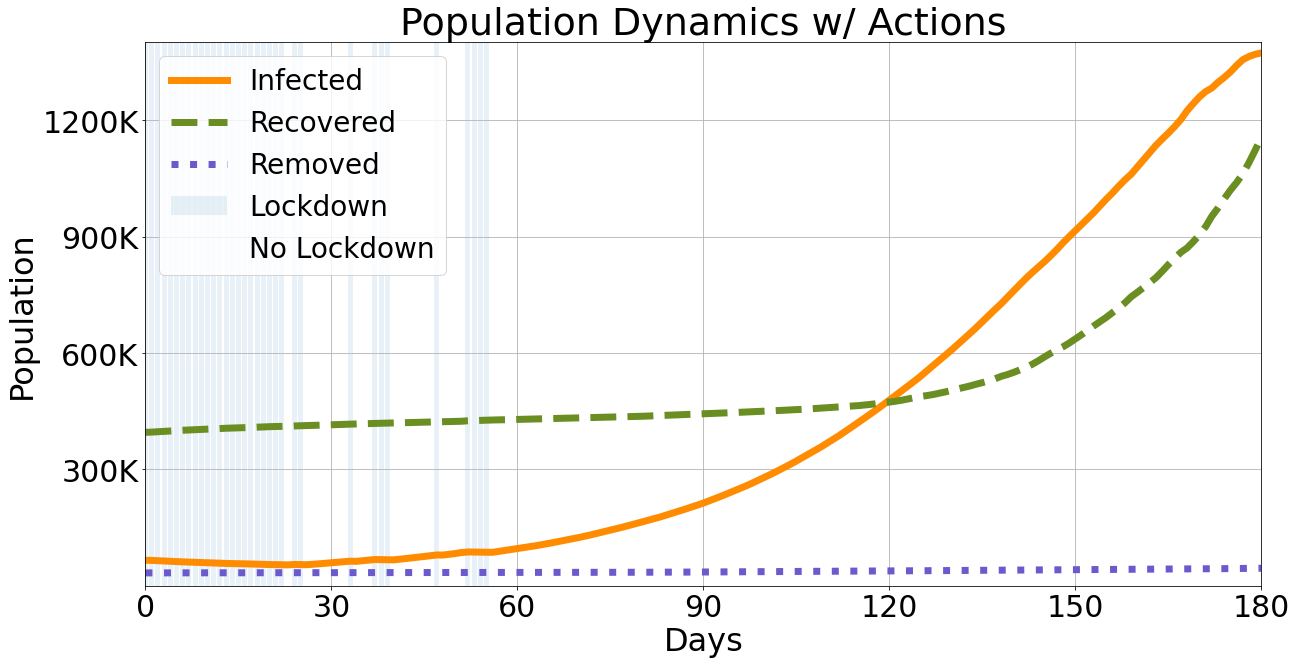

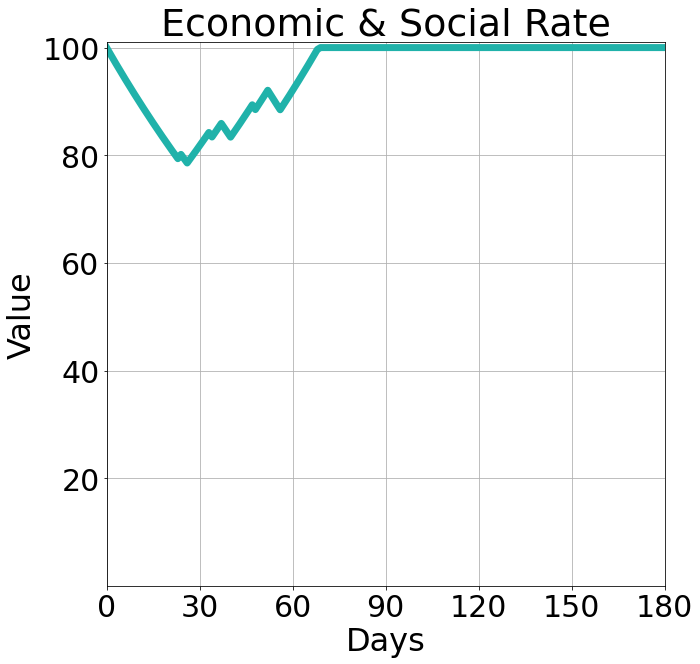



 Iteration 2
Time to generate samples: 34.54063820838928
Time to train: 577.4239656925201
Timestep: 180 Number of Healthy People: 14359674 Number of Infected People: 2933349 Number of Dead People: 61737 Number of Recovered People: 2098801 GDP: 100
Day 30 Infected: 118775 Day 30 Recovered: 423672 Day 30 Dead: 33749 Day 30 Healthy: 18877365 Day 30 GDP: 80.94040256544035
Day 45 Infected: 169441 Day 45 Recovered: 438093 Day 45 Dead: 34182 Day 45 Healthy: 18811845 Day 45 GDP: 86.7443605837768
Day 60 Infected: 245464 Day 60 Recovered: 454581 Day 60 Dead: 34855 Day 60 Healthy: 18718661 Day 60 GDP: 91.12361928167404
Day 90 Infected: 539955 Day 90 Recovered: 491991 Day 90 Dead: 38393 Day 90 Healthy: 18383222 Day 90 GDP: 100
Day 120 Infected: 1177341 Day 120 Recovered: 566900 Day 120 Dead: 45195 Day 120 Healthy: 17664125 Day 120 GDP: 100
Day 150 Infected: 2139911 Day 150 Recovered: 954475 Day 150 Dead: 53312 Day 150 Healthy: 16305863 Day 150 GDP: 100
Day 180 Infected: 2933349 Day 180 Recovered

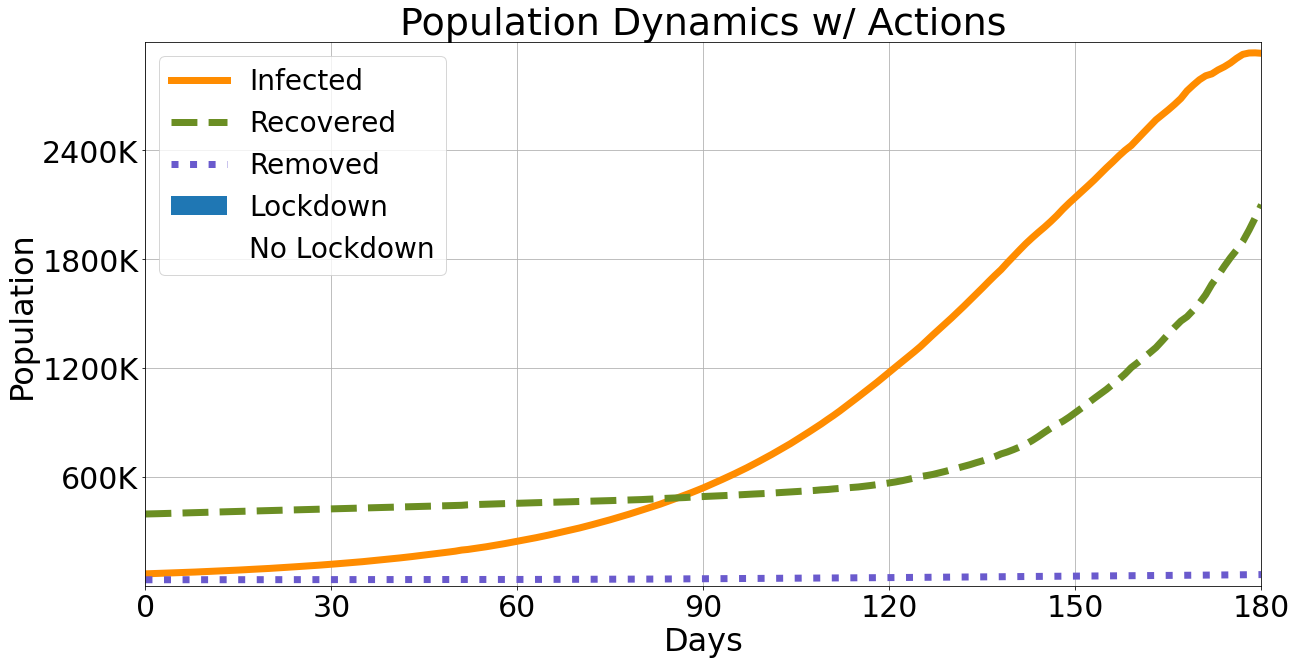

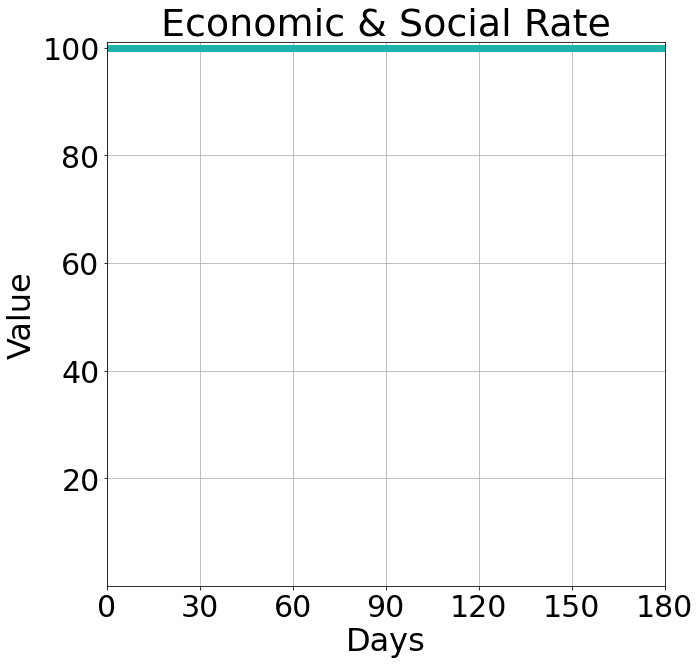



 Iteration 3
Time to generate samples: 32.126566886901855
Time to train: 761.9082775115967


KeyboardInterrupt: 

In [11]:
awr_agent = AdvantageWeightedRegression(disease_mitigation_environment, alternate_network=False,
                                        offline_memory_size=100_000, iterations=25)

### Comparison of Population Dynamics for Different Agents

In [ ]:
# # Actual Data
# covid_data = pd.read_csv('./covid_ny.csv')
# active_cases = [covid_data['Active Cases'][i] for i in range(203, 383)]
# total_recoveries = [covid_data['Total Recovered'][i] for i in range(203, 383)]
# total_deaths = [covid_data['Total Deaths'][i] for i in range(203, 383)]
# healthy_individuals = [19_453_561 - covid_data['Active Cases'][i] - covid_data['Total Recovered'][i] - covid_data['Total Deaths'][i] for i in range(203, 383)]

#### Comparison of Infected Individuals

In [ ]:
# plt.figure(figsize=(15, 10))
# plt.plot(awr_agent.population_dynamics[16][0], label='AWR', color='green', linewidth=7)
# plt.plot(double_dqn_agent.population_dynamics[7][0], label='DDQN', linestyle='dotted', color='dodgerblue', linewidth=7)
# plt.plot(active_cases, label='NY Data', linestyle='dashed', color='red', linewidth=7)
# plt.legend(fontsize=28)
# plt.xlabel('Days', fontsize=32)
# plt.ylabel('Population', fontsize=32)
# plt.title('Dynamics of Infected Individuals', fontsize=36)
# plt.grid()
# plt.xticks(np.arange(0, 181, 30), fontsize=30)
# plt.yticks([200000,400000,600000,800000], ["200K", "400K", "600K", "800K"], fontsize=30)
# plt.xlim(xmin=0, xmax=180)
# plt.ylim(ymin=0)
# plt.show()

#### Comparison of Dead Individuals 

In [ ]:
# plt.figure(figsize=(15, 10))
# # Infected Comparison
# plt.plot(awr_agent.population_dynamics[16][2], label='AWR', color='green', linewidth=7)
# plt.plot(double_dqn_agent.population_dynamics[7][2], label='DDQN', linestyle='dotted', color='dodgerblue', linewidth=7)
# plt.plot(total_deaths, label='NY Data', linestyle='dashed', color='red', linewidth=7)
# plt.legend(fontsize=28)
# plt.xlabel('Days', fontsize=32)
# plt.ylabel('Population', fontsize=32)
# plt.title('Dynamics of Removed Individuals', fontsize=36)
# plt.grid()
# plt.xticks(np.arange(0, 181, 30), fontsize=30)
# plt.yticks([35000, 40000, 45000, 50000], ["35K", "40K", "45K", "50K"], fontsize=30)
# plt.xlim(xmin=0, xmax=180)
# plt.show()

#### Comparison of Healthy Individuals

In [ ]:
# plt.figure(figsize=(15, 10))
# # Infected Comparison
# plt.plot(awr_agent.population_dynamics[16][3], label='AWR', color='green', linewidth=7)
# plt.plot(double_dqn_agent.population_dynamics[7][3], label='DDQN', linestyle='dotted', color='dodgerblue', linewidth=7)
# plt.plot(healthy_individuals, label='NY Data', linestyle='dashed', color='red', linewidth=7)
# plt.legend(fontsize=28)
# plt.xlabel('Days', fontsize=32)
# plt.ylabel('Population', fontsize=32)
# plt.title('Dynamics of Healthy Individuals', fontsize=36)
# plt.grid()
# plt.xticks(np.arange(0, 181, 30), fontsize=30)
# plt.yticks(fontsize=30)
# plt.yticks([17_500_000,18_000_000,18_500_000,19_000_000], ["17.5M", "18M", "18.5M", "19M"], fontsize=30)
# plt.xlim(xmin=0, xmax=180)
# # plt.ylim(ymin=0)
# plt.show()